In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
#for importing other python files
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Final Models/CNN-Dailymail Seq2Seq GRU with Attention/')
from attention import AttentionLayer

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import random
import math
import time
import pickle
# from bs4 import BeautifulSoup

import torch
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if(device.type == 'cuda'):
    print(f'GPU available: {torch.cuda.get_device_name()}')
else:
    print(f'Using CPU: {device.type}')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
GPU available: Tesla P100-PCIE-16GB


In [ ]:
SEED = 2020
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize

# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()

# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#   process = psutil.Process(os.getpid())
#   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

# printm()

In [ ]:
# data = torch.load('/content/drive/My Drive/Colab Notebooks/data/cnn dailymail/cnn_dailymail_train')

In [ ]:
# data['article'] = data['article'].str.decode('utf-8')
# data['summary'] = data['summary'].str.decode('utf-8')

In [ ]:
# data

In [ ]:
# data.drop_duplicates(subset=['article'],inplace=True)  #dropping duplicates
# data.dropna(axis=0,inplace=True)   #dropping na
# print(len(data))

In [ ]:
# contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

#                            "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

#                            "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

#                            "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

#                            "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

#                            "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

#                            "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

#                            "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

#                            "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

#                            "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

#                            "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

#                            "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

#                            "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

#                            "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

#                            "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

#                            "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

#                            "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

#                            "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

#                            "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

#                            "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

#                            "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

#                            "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

#                            "you're": "you are", "you've": "you have"}


# stop_words = set(stopwords.words('english'))

# def text_cleaner(text):
#     newString = text.lower()
#     # newString = BeautifulSoup(newString, "lxml").text
#     # newString = re.sub(r'\([^()]*\)', '', newString) #removes text inside parenthesis
#     # newString = re.sub('"','', newString) # no use
#     newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
#     newString = re.sub(r"'s\b","",newString) # detects word boundary
#     newString = re.sub("[^0-9a-zA-Z%]", " ", newString)
#     tokens = [w for w in newString.split() if not w in stop_words] #removing STOPWORDS
#     tokens = newString.split()
#     long_words=[]
#     for i in tokens:
#         if len(i)>1:                  #removing short word
#             long_words.append(i)
#     return (" ".join(long_words)).strip()


In [ ]:
# cleaned_article = []
# cleaned_summary = []
# for i,t in enumerate(zip(data['article'],data['summary'])):
#     if(i%10000 == 0):
#         print(i)
#     cleaned_article.append(text_cleaner(t[0]))
#     cleaned_summary.append(text_cleaner(t[1]))

# data['cleaned_article'] = cleaned_article
# data['cleaned_summary'] = cleaned_summary
# data['cleaned_summary'].replace('', np.nan, inplace=True)
# data.dropna(axis=0,inplace=True)
# data.info()

In [ ]:
# data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [ ]:
# data['cleaned_summary'][0], data['cleaned_article'][0]

In [ ]:
# for i in range(5):
#     print("Review:",data['cleaned_article'][i])
#     print("Summary:",data['cleaned_summary'][i])
#     print("\n")

In [ ]:
# text_word_count = []
# summary_word_count = []

# # populate the lists with sentence lengths
# for i in data['cleaned_article']:
#       text_word_count.append(len(i.split()))

# for i in data['cleaned_summary']:
#       summary_word_count.append(len(i.split()))

# #length_df = pd.DataFrame({'text':text_word_count,'summary':summary_word_count})
# #length_df.hist(bins = 25)
# #plt.show()
# #An "interface" to matplotlib.axes.Axes.hist() method
# plt.hist(x=text_word_count, bins=50, color='#0504aa')
# plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('text Word Count')
# plt.show()

In [ ]:
# plt.hist(x=summary_word_count, bins='auto', color='#0504aa')
# plt.grid(axis='y', alpha=0.75)
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.title('text Word Count')
# plt.show()

In [ ]:
max_len_text=1000
max_len_summary=200

In [ ]:
# from sklearn.model_selection import train_test_split
# x_tr,x_val,y_tr,y_val = train_test_split(data['cleaned_article'],data['cleaned_summary'],test_size=0.2,random_state=0,shuffle=True) 

In [ ]:
# #prepare a tokenizer for reviews on training data
# x_tokenizer = Tokenizer(num_words=100000)
# x_tokenizer.fit_on_texts(list(x_tr))

# #convert text sequences into integer sequences
# x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
# x_val   =   x_tokenizer.texts_to_sequences(x_val)

# #padding zero upto maximum length
# x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
# x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

# # x_voc_size   =  len(x_tokenizer.word_index) +1

In [ ]:
x_voc_size = 100001

In [ ]:
# torch.save(x_tokenizer,'/content/drive/My Drive/Colab Notebooks/Final Models/CNN-Dailymail Seq2Seq GRU with Attention/x_tokenizer')
# torch.save(x_tr,'/content/drive/My Drive/Colab Notebooks/Final Models/CNN-Dailymail Seq2Seq GRU with Attention/x_tr')
# torch.save(x_val,'/content/drive/My Drive/Colab Notebooks/Final Models/CNN-Dailymail Seq2Seq GRU with Attention/x_val')

In [ ]:
# #preparing a tokenizer for summary on training data 
# y_tokenizer = Tokenizer(num_words=50000)
# y_tokenizer.fit_on_texts(list(y_tr))

# #convert summary sequences into integer sequences
# y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
# y_val   =   y_tokenizer.texts_to_sequences(y_val) 

# #padding zero upto maximum length
# y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
# y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

# # y_voc_size  =   len(y_tokenizer.word_index) +1

In [ ]:
y_voc_size = 50001

In [ ]:
# torch.save(y_tokenizer,'/content/drive/My Drive/Colab Notebooks/Final Models/CNN-Dailymail Seq2Seq GRU with Attention/y_tokenizer')
# torch.save(y_tr,'/content/drive/My Drive/Colab Notebooks/Final Models/CNN-Dailymail Seq2Seq GRU with Attention/y_tr')
# torch.save(y_val,'/content/drive/My Drive/Colab Notebooks/Final Models/CNN-Dailymail Seq2Seq GRU with Attention/y_val')

In [ ]:
x_tokenizer = torch.load('/content/drive/My Drive/Colab Notebooks/Final Models/CNN-Dailymail Seq2Seq GRU with Attention/x_tokenizer')
x_tr = torch.load('/content/drive/My Drive/Colab Notebooks/Final Models/CNN-Dailymail Seq2Seq GRU with Attention/x_tr')
x_val = torch.load('/content/drive/My Drive/Colab Notebooks/Final Models/CNN-Dailymail Seq2Seq GRU with Attention/x_val')

y_tokenizer = torch.load('/content/drive/My Drive/Colab Notebooks/Final Models/CNN-Dailymail Seq2Seq GRU with Attention/y_tokenizer')
y_tr = torch.load('/content/drive/My Drive/Colab Notebooks/Final Models/CNN-Dailymail Seq2Seq GRU with Attention/y_tr')
y_val = torch.load('/content/drive/My Drive/Colab Notebooks/Final Models/CNN-Dailymail Seq2Seq GRU with Attention/y_val')

In [ ]:
from tensorflow.keras import backend as K 
K.clear_session() 
latent_dim = 300 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#GRU 1 
encoder_gru1 = GRU(latent_dim, return_sequences=True, return_state=True, dropout=0.4) 
encoder_output1, state_h1 = encoder_gru1(enc_emb) 

#GRU 2 
encoder_gru2 = GRU(latent_dim, return_sequences=True, return_state=True, dropout=0.4) 
encoder_output2, state_h2 = encoder_gru2(encoder_output1) 

#GRU 3 
encoder_gru3 = GRU(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h = encoder_gru3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#GRU using encoder_states as initial state
decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs, decoder_fwd_state = decoder_gru(dec_emb, initial_state=state_h) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder GRU output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1000, 300)    30000300    input_1[0][0]                    
__________________________________________________________________________________________________
gru (GRU)                       [(None, 1000, 300),  541800      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=3500):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(1000)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='Adam'
)
# import tensorflow_addons as tfa
# optimizer = tfa.optimizers.AdamW(
#     weight_decay = 1e-04,
#     learning_rate = 0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, name='AdamW'
# )

Text(0.5, 0, 'Train Step')

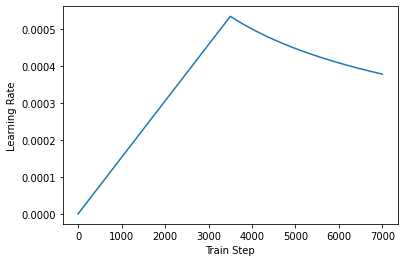

In [ ]:
temp_learning_rate_schedule = CustomSchedule(1000)

plt.plot(temp_learning_rate_schedule(tf.range(7000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [ ]:
model.compile(optimizer, loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [ ]:
# def decay(epoch):
#   if epoch <= 2:
#     return 1e-03
#   else:
#     return 1e-04

# lr_callback = tf.keras.callbacks.LearningRateScheduler(decay)

In [ ]:
# # Callback for printing the LR at the end of each epoch.
# class PrintLR(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=None):
#     print('\nLearning rate for epoch {} is {}'.format(epoch + 1, model.optimizer.lr)

In [ ]:
# import datetime

# todays_date = datetime.date.today()
# print(todays_date)

# # adding strftime will remove the seconds
# current_time = datetime.datetime.now().strftime('%H:%M')
# print(current_time)

In [ ]:
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/Final Models/CNN-Dailymail Seq2Seq GRU v2 with Attention/cp-{epoch:02d}.ckpt"
# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_best_only = True,
    save_freq='epoch'
)

In [ ]:
checkpoint_dir = '/content/drive/My Drive/Colab Notebooks/Final Models/CNN-Dailymail Seq2Seq GRU v2 with Attention/'
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
print(latest_checkpoint)

/content/drive/My Drive/Colab Notebooks/Final Models/CNN-Dailymail Seq2Seq GRU v2 with Attention/cp-01.ckpt


In [ ]:
model.load_weights(latest_checkpoint)

In [ ]:
# Save the weights using the `checkpoint_path` format
# model.save_weights(checkpoint_path.format(epoch=1))

In [ ]:
history=model.fit(
    [x_tr,y_tr[:,:-1]], 
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
    epochs=2,
    callbacks=[es, 
               cp_callback
               ],
    batch_size=32, 
    validation_data=([x_val,y_val[:,:-1]],y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]),
    verbose=1
)

Epoch 1/2
7101/7101 [==============================] - ETA: 0s - loss: 0.8283
Epoch 00001: val_loss improved from inf to 1.18419, saving model to /content/drive/My Drive/Colab Notebooks/Final Models/CNN-Dailymail Seq2Seq GRU v2 with Attention/cp-01.ckpt
7101/7101 [==============================] - 14268s 2s/step - loss: 0.8283 - val_loss: 1.1842
Epoch 2/2
5606/7101 [======================>.......] - ETA: 46:49 - loss: 0.8157

In [ ]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [ ]:
reverse_target_word_index = y_tokenizer.index_word 
reverse_source_word_index = x_tokenizer.index_word 
target_word_index = y_tokenizer.word_index

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2 = decoder_gru(dec_emb2, initial_state=[decoder_state_input_h])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h],
    [decoder_outputs2] + [state_h2]
)

In [ ]:
from random import choice
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

def select_topk(outp, k=5):
    probs = F.softmax(outp,dim=-1)
    vals,idxs = probs.topk(k, dim=-1)
    return idxs[torch.randint(k, (1,))]

def select_nucleus(outp, p=0.5):
    probs = F.softmax(outp,dim=-1)
    idxs = torch.argsort(probs, descending=True)
    res,cumsum = [],0.
    for idx in idxs:
        res.append(idx)
        cumsum += probs[idx]
        if cumsum>p: return idxs.new_tensor([choice(res)])

In [ ]:
def decode_sequence(input_seq):
    # val = []
    val2 = []
    # Encode the input as state vectors.
    e_out, e_h = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h = decoder_model.predict([target_seq] + [e_out, e_h])

        # Sample a token
        try:
            sampled_token_index = np.argmax(output_tokens[0, -1, :])
            # print(type(output_tokens))
            # print(len(output_tokens))
            # val.append(output_tokens)
            # val.append(reverse_target_word_index[select_nucleus(torch.tensor(output_tokens[0][0])).item()])
            val2.append(reverse_target_word_index[select_topk(torch.tensor(output_tokens[0][0]),3).item()])

            #print("sampled_token_index: ",sampled_token_index)
            sampled_token = reverse_target_word_index[sampled_token_index]

            if(sampled_token!='end'):
                decoded_sentence += ' '+sampled_token

                # Exit condition: either hit max length or find stop word.
                if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                    stop_condition = True

            # Update the target sequence (of length 1).
            target_seq = np.zeros((1,1))
            target_seq[0, 0] = sampled_token_index

            # Update internal states
            e_h = h
        except KeyError:
            break
        
    return decoded_sentence,val2

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
# select_nucleus(torch.tensor(val[0][0][0])).item(), select_topk(torch.tensor(val[0][0][0]),5).item()

In [ ]:
for i in range(len(x_tr)):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    pred_sum,val2 = decode_sequence(x_tr[i].reshape(1,max_len_text))
    print("Predicted summary: ",pred_sum)
    # print(f"Prediction: {' '.join(val)}")
    print(f"Prediction: {' '.join(val2)}")
    print("\n")
    if(i==10):
        break;

Review: by michael zennie published 00 49 est 29 september 2013 updated 16 35 est 30 september 2013 start of it all 2009 obituary photo for josephine patterson mrs ruckinger grandmother and apparent namesake ruckinger first split with her family after allegedly bleeding her grandmother dry as she died 20 years ago long running feud in pennsylvania family ended in violence after woman and her husband broke into her parents home and killed her mother and brother before the two were shot dead by the woman own father police have revealed today the horrific violence friday night that left four dead and only one survivor in the house in rural pennsylvania may have been sparked over lingering resentment over inheritance family member revealed exclusively to mailonline josephine ruckinger 43 hated her family and plotted with her husband jeffrey ruckinger 43 to murder all of them in their house on friday night mrs ruckinger who had been estranged from her family for years rang the doorbell at h

In [ ]:
for i in range(len(x_val)):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    pred_sum,val2 = decode_sequence(x_val[i].reshape(1,max_len_text))
    print("Predicted summary: ",pred_sum)
    # print(f"Prediction: {' '.join(val)}")
    print(f"Prediction: {' '.join(val2)}")
    print("\n")
    if(i==10):
        break;

Review: pensioner benefits including free tv licences bus passes and help with heating bills could be cut under government plans to limit welfare spending iain duncan smith warned existing protections for raft of benefits would have to disappear once the government sets limit on the 100billion welfare bill the state pension will be specifically excluded but the work and pensions secretary made clear that additional payments made to pensioners would not be exempt from any future squeeze work and pensions secretary iain duncan smith said most protecting benefits would have be removed there is growing tension in the cabinet over where up to 12billion in benefit cuts should fall chancellor george osborne has made clear the pain should be felt by working age claimants but the lib dems and even some senior tories are dismayed at the reluctance to consider cuts to pensioner perks david cameron has vowed to honour his 2010 election pledge not to cut pension benefits including the winter fuel a

In [ ]:
!pip install rouge-score
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog', 'The quick brown dog jumps on the log.')